In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import xgboost as xgb
from utils import *

In [3]:
x2dmi, x1nino, tropical_AU, mjo = get_data()

In [4]:
# run for one grid point
lat, lon = -19.5, 144.5
data = get_one_grid_ts(x2dmi, x1nino, tropical_AU, mjo, lat, lon)
# define run config
config = {
    'val_start_date': '2000-01-01',
    'test_size': 0.2,
    'random_state': 123,
    "model_params":{}
}



<AxesSubplot:>

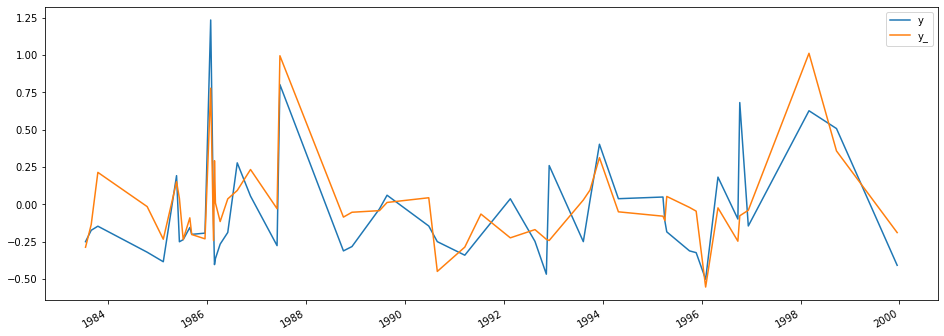

In [125]:
# regressor
rsl=run_once(data, config)

rmse = rsl[0]
fimp = rsl[1]
df_test =rsl[2]
df_eval = rsl[3]
ft_name = rsl[4]
ft_lag = rsl[5]
r_2=rsl[6]
df_test.iloc[:50].plot(figsize=(16,6))

In [9]:
data

,DMI,enso,apcp,IHR1,IHR2
1981-11-04,NaN,NaN,NaN,NaN,NaN
1981-11-11,NaN,NaN,NaN,NaN,NaN
1981-11-18,-0.276452,-0.486080,1.143462,0.294111,0.226339
1981-11-25,-0.288649,-0.288734,1.198358,0.313421,-0.054568
1981-12-02,-0.175542,-0.205299,1.221760,0.699190,0.477167
...,...,...,...,...,...
2014-12-03,-0.037669,0.931215,-0.205890,0.216670,0.116530
2014-12-10,-0.195798,0.866189,-0.141693,0.063980,0.113737
2014-12-17,-0.341515,0.771764,-0.184310,-0.058060,-0.000763
2014-12-24,-0.489387,0.636742,0.071477,-0.126630,-0.161748


In [31]:
def model_rain_percentile(levels, df_, config):
    df=df_.copy()
    perc = [np.percentile(df['apcp'].dropna(), x) for x in levels]
    df['apcp'] = pd.cut(df['apcp'], bins=perc,labels=levels[1:])
    X_train, y_train, X_test, y_test, X_eval, y_eval = split_data(df, config)
    

#     categorical_pipeline = Pipeline(
#     steps=[
#     ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
#     ]
#     )
    
#     numeric_pipeline = Pipeline(
#     steps=[("scale", StandardScaler())]
#     )
    
    
    pipeline = Pipeline([
        ('standard', StandardScaler()),
        ('model', xgb.XGBClassifier(**config['model_params']))
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    # rmse
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r_2 = r2_score(y_test, preds)
    print(rmse)

    # feature importance
    fimp = pd.DataFrame({
        'importance': pipeline.steps[-1][1].feature_importances_
    }, index=X_train.columns)
    best_ft = fimp.loc[fimp['importance'].idxmax()].name
    if '_' in best_ft:
        ft_name, lag = best_ft.split('_')
        lag = int(lag)
    else:
        ft_name=best_ft
        lag=0

    df_test = pd.DataFrame({
    'y':y_test.to_list(),
    'y_':preds
    },index=y_test.index)
    df_eval = pd.DataFrame({
    'y':y_eval.to_list(),
    'y_':pipeline.predict(X_eval)
    },index=y_eval.index)

    return df_test, df_eval

In [32]:
# classifier
levels = np.arange(10,100,10)
rsl =  model_rain_percentile(levels, data, config)
df_test = rsl[0]
df_eval = rsl[1]

/Users/dongxiay/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:56:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
22.283970527393752


In [46]:
levels = np.arange(10,100,10)
perc = [np.percentile(data['apcp'].dropna(), x) for x in levels]
perc

[-0.3699086731299758,
 -0.30086959078907966,
 -0.25719857551157477,
 -0.22110200636088848,
 -0.16149196960031986,
 -0.07969571948051453,
 0.04766228670487119,
 0.2415017187595371,
 0.6265449540689586]

In [47]:
levels = np.arange(33,100,33)
perc = [np.percentile(data['apcp'].dropna(), x) for x in levels]
perc

[-0.2474021752551198, -0.010897020362317435, 2.042994700111451]

<AxesSubplot:>

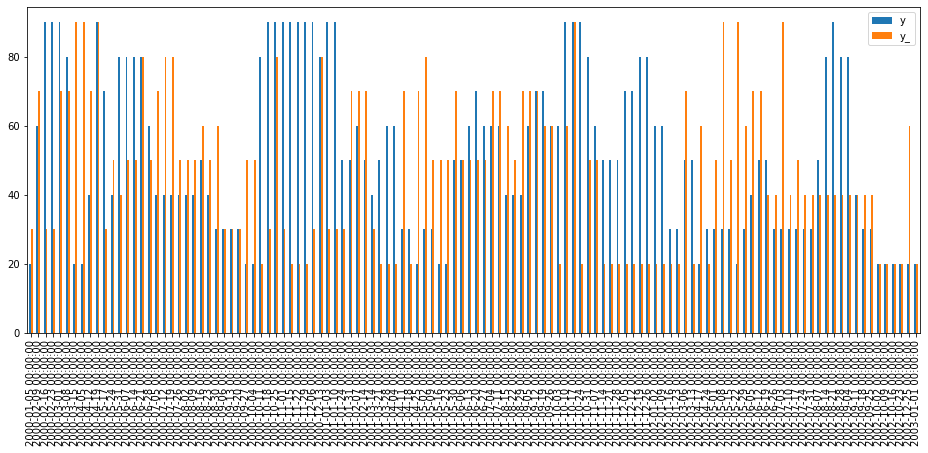

In [41]:
df_eval.iloc[:120].plot(kind='bar', figsize=(16,6))

<AxesSubplot:>

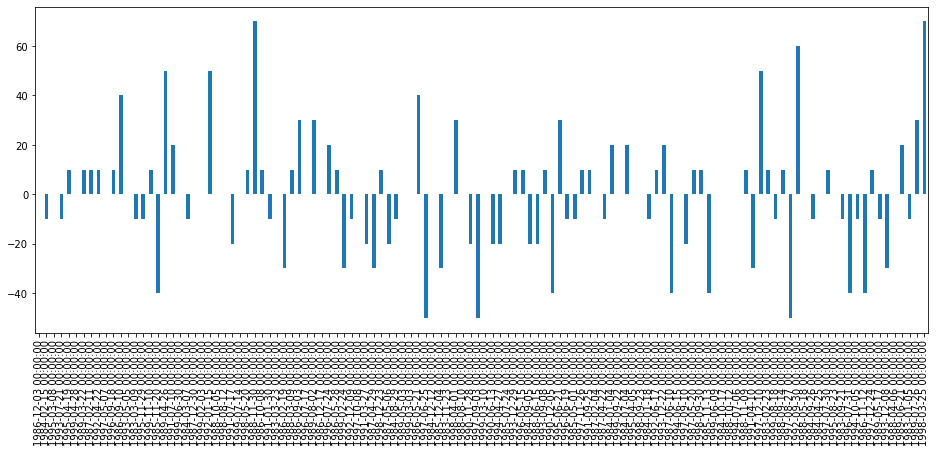

In [40]:
(df_test['y_']-df_test['y']).iloc[:120].plot(kind='bar', figsize=(16,6))